# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [3]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

import pandas as pd
import glob
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [4]:
# Write your answer here

#Guinea

guinea = pd.DataFrame()

#we iterate in guinea_data folder and append every .csv file to our 'guinea' dataframe
for file in glob.glob(DATA_FOLDER+"/ebola/guinea_data/"+'*.csv'):
    eb = pd.read_csv(file, parse_dates=['Date']) # here we parse column 'Date' so we can handle dates easier
    guinea = guinea.append(eb)

#we set the index to 'Date' and 'Description' and we only need the 'Totals' column to copmute the daily averages
guinea = (guinea.set_index(['Date','Description'])['Totals']).unstack('Description') #we make 'Description' values as column headers

#we make a set of months so we can calculate the average
months = set(guinea.index.month) #this way we get all months but the set deletes the duplicates
new_cases = {}
new_deaths = {}

#now we iterate through our set of months and calculate the daily average of new cases and deaths
for month in months: 
    #this is an easy way to get how many days has a particular month
    days_in_month = (guinea.index.daysinmonth[guinea.index.month==month])[0] 
    
    #here we look for all data from the same month and find the column named 'Total new cases registered so far'
    #and just sum all values
    month_sum_cases = (guinea[guinea.index.month==month])['Total new cases registered so far'].astype(float).sum()
    
    #for monthly deaths it's the same thing except we have in one file different column name, so we must handle both cases
    month_sum_deaths1 = (guinea[guinea.index.month==month])['New deaths registered'].astype(float).sum()
    month_sum_deaths2 = (guinea[guinea.index.month==month])['New deaths registered today'].astype(float).sum()
    month_sum_deaths = np.nansum([month_sum_deaths1, month_sum_deaths2])

    #calculate the daily average for both cases and deaths and append them to dict where the key is '2014'+month   
    new_cases["2014-"+str(month)] = month_sum_cases/days_in_month
    new_deaths["2014-"+str(month)] = month_sum_deaths/days_in_month
    
#make two new dataframes from dict, one for cases, one for deaths and merge them into one dataframe - 'guinea_final'
guinea_new_cases = pd.DataFrame.from_dict(new_cases, orient='index')
guinea_new_cases.index.name = 'Month'
guinea_new_cases.columns = ['Daily average new cases']
guinea_new_cases['Country'] = 'Guinea'

guinea_deaths = pd.DataFrame.from_dict(new_deaths, orient='index')
guinea_deaths.index.name = 'Month'
guinea_deaths.columns = ['Daily average deaths']

guinea_final = pd.merge(guinea_new_cases, guinea_deaths, left_index=True, right_index=True)
guinea_final = guinea_final.set_index(['Country', guinea_final.index]) 

#for next countries we make almost everything the same, except for few things which will be noted

#Liberia

liberia = pd.DataFrame()

for file in glob.glob(DATA_FOLDER+"/ebola/liberia_data/"+'*.csv'):
    eb = pd.read_csv(file, parse_dates=['Date'])
    liberia = liberia.append(eb)

liberia = (liberia.set_index(['Date', 'Variable']))['National']
liberia = pd.pivot_table(liberia.reset_index(), index='Date', columns='Variable', values='National')
liberia = liberia.fillna(0)

months = set(liberia.index.month)
new_cases = {}
new_deaths = {}
for month in months:
    days_in_month = (liberia.index.daysinmonth[liberia.index.month==month])[0]
    
    #here we had more expressions for new cases to handle
    month_sum_cases1 = (liberia[liberia.index.month==month])['New Case/s (Suspected)'].astype(float).sum()
    month_sum_cases2 = (liberia[liberia.index.month==month])['New Case/s (Probable)'].astype(float).sum()
    month_sum_cases3 = (liberia[liberia.index.month==month])['New case/s (confirmed)'].astype(float).sum()
    month_sum_cases = np.nansum([month_sum_cases1, month_sum_cases2, month_sum_cases3])
    
    month_sum_deaths = (liberia[liberia.index.month==month])['Newly reported deaths'].astype(float).sum()

    new_cases["2014-"+str(month)] = month_sum_cases/days_in_month
    new_deaths["2014-"+str(month)] = month_sum_deaths/days_in_month
    
liberia_new_cases = pd.DataFrame.from_dict(new_cases, orient='index')
liberia_new_cases.index.name = 'Month'
liberia_new_cases.columns = ['Daily average new cases']
liberia_new_cases['Country'] = 'Liberia'

liberia_deaths = pd.DataFrame.from_dict(new_deaths, orient='index')
liberia_deaths.index.name = 'Month'
liberia_deaths.columns = ['Daily average deaths']

liberia_final = pd.merge(liberia_new_cases, liberia_deaths, left_index=True, right_index=True)
liberia_final = liberia_final.set_index(['Country', liberia_final.index])

#Sierra Leone

sierra = pd.DataFrame()

for file in glob.glob(DATA_FOLDER+"/ebola/sl_data/"+'*.csv'):
    eb = pd.read_csv(file, na_values=['-'], parse_dates=['date'])
    sierra = sierra.append(eb)
    
sierra_copy = sierra.copy()
sierra_copy = sierra_copy.fillna(0)
sierra = (sierra.set_index(['date','variable'])['National'])
sierra = pd.pivot_table(sierra.reset_index(), index='date', columns='variable', values='National', aggfunc='first')
sierra = sierra.fillna(0)

#this one was the hardest because there are files that contain values in column 'National' which represent the sum of 
#new cases or deaths, but also there are files where we need manualy to sum the values because 'National' value is empty
months = set(sierra.index.month)
new_cases = {}
new_deaths = {}
for month in months:
    days_in_month = (sierra.index.daysinmonth[sierra.index.month==month])[0]
    
    #first we get all 'National' values for column 'etc_new_deaths' in one month
    month_sum_deaths = 0
    month_deaths = (sierra[sierra.index.month==month])['etc_new_deaths'].astype(float)
    for i in range(len(month_deaths)): #then we iterate for every value(every value represents one day or file)
    #if the 'National' value for that file is '0', then then we sum the 'etc_new_deaths'
    #for every other column(cities) and we get the sum for that day and add it to the monthly sum 'month_sum_deaths' 
        if month_deaths[i]==0: 
            temp = (sierra_copy[sierra_copy.date.dt.month==month])
            month_sum_deaths += (temp.loc[temp['variable']=='etc_new_deaths'].drop(['date', 'variable', 'National'], axis=1).iloc[i].astype(float).sum())
        #if the 'National' value is not '0', then we don't need to calculate anything,
        #we just add the value for that day to the monthly sum
        else: 
            month_sum_deaths += month_deaths[i]
    
    #the same thing goes with 'new cases', except we need to handle 4 different expressions
    month_sum_cases = 0
    month_cases1 = (sierra[sierra.index.month==month])['new_noncase'].astype(float)
    for i in range(len(month_cases1)):
        if month_cases1[i]==0:
            temp = (sierra_copy[sierra_copy.date.dt.month==month])
            month_sum_cases += (temp.loc[temp['variable']=='new_noncase'].drop(['date', 'variable', 'National'], axis=1).iloc[i].astype(float).sum())
        else:
            month_sum_cases += month_cases1[i]
    month_cases2 = (sierra[sierra.index.month==month])['new_suspected'].astype(float)
    for i in range(len(month_cases2)):
        if month_cases2[i]==0:
            temp = (sierra_copy[sierra_copy.date.dt.month==month])
            month_sum_cases += (temp.loc[temp['variable']=='new_suspected'].drop(['date', 'variable', 'National'], axis=1).iloc[i].astype(float).sum())
        else:
            month_sum_cases += month_cases2[i]
    month_cases3 = (sierra[sierra.index.month==month])['new_probable'].astype(float)
    for i in range(len(month_cases3)):
        if month_cases3[i]==0:
            temp = (sierra_copy[sierra_copy.date.dt.month==month])
            month_sum_cases += (temp.loc[temp['variable']=='new_probable'].drop(['date', 'variable', 'National'], axis=1).iloc[i].astype(float).sum())
        else:
            month_sum_cases += month_cases3[i]
    month_cases4 = (sierra[sierra.index.month==month])['new_confirmed'].astype(float)
    for i in range(len(month_cases4)):
        if month_cases4[i]==0:
            temp = (sierra_copy[sierra_copy.date.dt.month==month])
            month_sum_cases += (temp.loc[temp['variable']=='new_confirmed'].drop(['date', 'variable', 'National'], axis=1).iloc[i].astype(float).sum())
        else:
            month_sum_cases += month_cases4[i]

    new_cases["2014-"+str(month)] = month_sum_cases/days_in_month
    new_deaths["2014-"+str(month)] = month_sum_deaths/days_in_month
    
sierra_new_cases = pd.DataFrame.from_dict(new_cases, orient='index')
sierra_new_cases.index.name = 'Month'
sierra_new_cases.columns = ['Daily average new cases']
sierra_new_cases['Country'] = 'Sierra Leone'

sierra_deaths = pd.DataFrame.from_dict(new_deaths, orient='index')
sierra_deaths.index.name = 'Month'
sierra_deaths.columns = ['Daily average deaths']

sierra_final = pd.merge(sierra_new_cases, sierra_deaths, left_index=True, right_index=True)
sierra_final = sierra_final.set_index(['Country', sierra_final.index])

#at the end, we just create a new dataframe and append the data for every country
final_frame = pd.DataFrame()
final_frame = final_frame.append(guinea_final).append(liberia_final).append(sierra_final)
final_frame

Daily average new cases  Daily average deaths
Country      Month                                                 
Guinea       2014-8                  4.161290              0.548387
             2014-9                 10.466667              1.900000
             2014-10                 1.096774              0.483871
Liberia      2014-6                  1.333333              0.466667
             2014-7                  3.032258              1.516129
             2014-8                 10.806452              6.741935
             2014-9                 51.066667             28.833333
             2014-10                36.741935             22.612903
             2014-11                13.233333              6.733333
             2014-12              1503.451613              0.000000
Sierra Leone 2014-8                 24.741935              3.580645
             2014-9                 69.233333              4.333333
             2014-10               112.193548              3.354839
             2014-11               109.300000              0.400000
             2014-12                21.903226              0.354839

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [5]:
# Write your answer here

#first we initialize empty dataframe
data = pd.DataFrame()

#then we loop over 9 spreadsheets and append them to the empty dataframe
for i in range(1,10):
    mb = pd.read_excel(DATA_FOLDER+"/microbiome/MID"+str(i)+".xls", sheetname="Sheet 1", header=None)
    mb.columns = ['Taxon', 'Count'] #we name the columns
    mb['BARCODE']="MID"+str(i) #and add a nem column to know from which spreadsheet is the data 
    data = data.append(mb)
    
#we set the index to 'BARCODE' and 'Taxon' so that we have unique index
data = data.set_index(['BARCODE', 'Taxon'])

#just reading the metadata in separate dataframe and setting the index_col to 0 (that's the 'BARCODE' column)
metadata = pd.read_excel(DATA_FOLDER+"/microbiome/metadata.xls", sheetname="Sheet1", index_col=0)

#we merge two dataframes based on index column from data and index column from metadata ('BARCODE')
merged = pd.merge(data, metadata , left_index=True, right_index=True)

#we can check if index is unique
merged.index.is_unique

#finally we replace the NaN values with 'unknown'
merged = merged.fillna("unknown")
merged


Count  \
BARCODE Taxon                                                       
MID1    Archaea "Crenarchaeota" Thermoprotei Desulfuroc...      7   
        Archaea "Crenarchaeota" Thermoprotei Desulfuroc...      2   
        Archaea "Crenarchaeota" Thermoprotei Sulfolobal...      3   
        Archaea "Crenarchaeota" Thermoprotei Thermoprot...      3   
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...      7   
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...      1   
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...      1   
        Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...      1   
        Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...      1   
        Archaea "Euryarchaeota" Halobacteria Halobacter...      1   
        Archaea "Euryarchaeota" Halobacteria Halobacter...      4   
        Archaea "Euryarchaeota" Halobacteria Halobacter...      1   
        Archaea "Euryarchaeota" Halobacteria Halobacter...      2   
        Archaea "Euryarchaeota" Halobacteria Halobacter...      4   
        Archaea "Euryarchaeota" Methanococci Methanococ...      1   
        Archaea "Euryarchaeota" Methanopyri Methanopyra...     12   
        Archaea "Euryarchaeota" Thermoplasmata Thermopl...      2   
        Bacteria "Actinobacteria" Actinobacteria Actino...      2   
        Bacteria "Actinobacteria" Actinobacteria Actino...      1   
        Bacteria "Actinobacteria" Actinobacteria Actino...      1   
        Bacteria "Actinobacteria" Actinobacteria Actino...      1   
        Bacteria "Actinobacteria" Actinobacteria Actino...      2   
        Bacteria "Actinobacteria" Actinobacteria Actino...     53   
        Bacteria "Actinobacteria" Actinobacteria Actino...      1   
        Bacteria "Actinobacteria" Actinobacteria Actino...      2   
        Bacteria "Actinobacteria" Actinobacteria Actino...      3   
        Bacteria "Actinobacteria" Actinobacteria Actino...      1   
        Bacteria "Actinobacteria" Actinobacteria Actino...     99   
        Bacteria "Actinobacteria" Actinobacteria Actino...     17   
        Bacteria "Actinobacteria" Actinobacteria Actino...      2   
...                                                           ...   
MID9    Bacteria "Proteobacteria" Gammaproteobacteria O...     10   
        Bacteria "Proteobacteria" Gammaproteobacteria O...      1   
        Bacteria "Proteobacteria" Gammaproteobacteria O...      1   
        Bacteria "Proteobacteria" Gammaproteobacteria P...      1   
        Bacteria "Proteobacteria" Gammaproteobacteria P...     12   
        Bacteria "Proteobacteria" Gammaproteobacteria P...      4   
        Bacteria "Proteobacteria" Gammaproteobacteria P...    805   
        Bacteria "Proteobacteria" Gammaproteobacteria P...    862   
        Bacteria "Proteobacteria" Gammaproteobacteria P...     12   
        Bacteria "Proteobacteria" Gammaproteobacteria P...   3534   
        Bacteria "Proteobacteria" Gammaproteobacteria T...      4   
        Bacteria "Proteobacteria" Gammaproteobacteria T...      1   
        Bacteria "Proteobacteria" Gammaproteobacteria T...     25   
        Bacteria "Proteobacteria" Gammaproteobacteria T...      2   
        Bacteria "Proteobacteria" Gammaproteobacteria X...      3   
        Bacteria "Proteobacteria" Gammaproteobacteria X...      2   
        Bacteria "Proteobacteria" Gammaproteobacteria X...      1   
        Bacteria "Proteobacteria" Gammaproteobacteria X...      3   
        Bacteria "Proteobacteria" Gammaproteobacteria X...      2   
        Bacteria "Proteobacteria" Gammaproteobacteria X...      1   
        Bacteria "Synergistetes" Synergistia Synergista...      3   
        Bacteria "Tenericutes" Mollicutes Anaeroplasmat...      1   
        Bacteria "Tenericutes" Mollicutes Haloplasmatal...     11   
        Bacteria "Thermodesulfobacteria" Thermodesulfob...      1   
        Bacteria "Thermodesulfobacteria" Thermodesulfob...      1   
        Bacteria "Thermotogae" Thermotogae Thermotogale...

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [6]:
from IPython.core.display import HTML
#HTML(filename=DATA_FOLDER+'/titanic.html')

For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

1.

In [7]:
# Write your answer here
import matplotlib.pyplot as plot
titanic=pd.read_excel(DATA_FOLDER+'/titanic.xls')
titanic.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [8]:
titanic.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [9]:
#these attributes can be categorical
for col in ['pclass', 'survived', 'sex', 'embarked']:
    titanic[col] = titanic[col].astype('category')
titanic.dtypes

pclass       category
survived     category
name           object
sex          category
age           float64
sibsp           int64
parch           int64
ticket         object
fare          float64
cabin          object
embarked     category
boat           object
body          float64
home.dest      object
dtype: object

2.

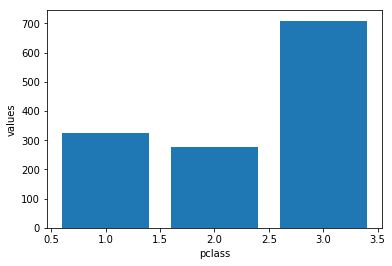

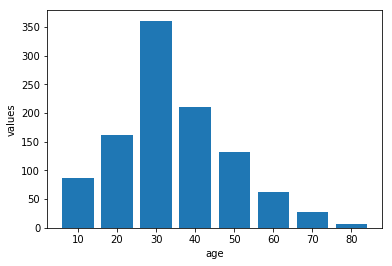

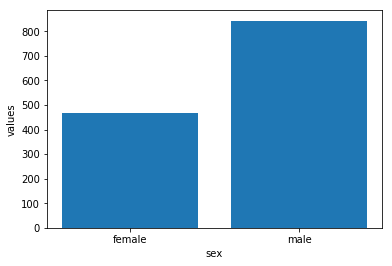

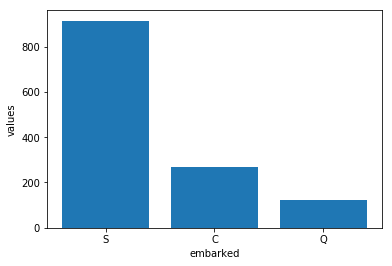

In [38]:
def histogram(data,column):
    uniques=data[column].unique()
    #print(uniques)
    if(type(uniques[0])==type("")):
        uniques=uniques[pd.notnull(uniques)]
        uniques.sort()
    else:
        uniques.sort()
    hist=[]
    if(column=='age'):
        decade_slots=int(max(uniques)/10)
        for i in range(0,decade_slots):
            hist.append(sum((data[column]>(i*10))&(data[column]<= (i+1)*10)))
    else:
        for unique in uniques:
            hist.append(sum(data[column]==unique))
    if(type(uniques[0])==type("")):
        plot.bar(range(0,len(uniques)),hist)
        plot.xticks(range(0,len(uniques)), uniques)
    elif(column=='age'):
        plot.bar([i*10 for i in range(1,decade_slots+1)],hist,width=8)
    else:
        plot.bar(uniques,hist)
    plot.xlabel(column)
    plot.ylabel('values')
    plot.show()
    return hist
pclass_hist=histogram(titanic,'pclass')
age_hist=histogram(titanic,'age')
sex_hist=histogram(titanic,'sex')
embarked_hist=histogram(titanic,'embarked')

3.

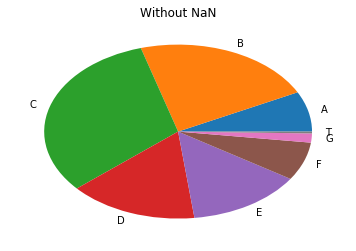

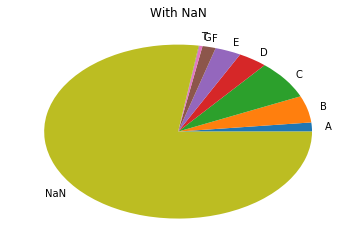

In [7]:
cabin=titanic['cabin'].unique()
null_cabin=pd.isnull(titanic['cabin'])
cabin=cabin[pd.notnull(cabin)]
cabin.sort()
cabinfloors=['A','B','C','D','E','F','G','T']
number=[]
total=0
for cabinfloor in cabinfloors:
    cabins=cabin[pd.Series(cabin).str.startswith(cabinfloor)]
    cabtotal=0
    for cab in cabins:
        cabtotal+=sum(titanic['cabin']==cab)
    number.append(cabtotal)
    total+=cabtotal
#pie without NaN values
plot.figure(0)
plot.title('Without NaN')
plot.pie(number,labels=cabinfloors)

#pie with NaN values
plot.figure(1)
cabinfloors.append("NaN")
number.append(sum(null_cabin))
plot.title('With NaN')
plot.pie(number,labels=cabinfloors)
plot.show()

4.

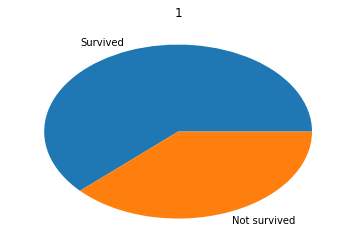

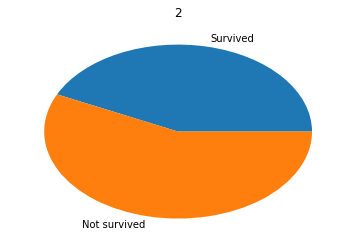

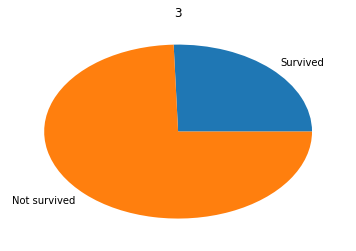

In [8]:
pclasses=titanic['pclass'].unique()
pclasses.sort()
percentages=[]
for pclass in pclasses:
    passengers=titanic[titanic['pclass']==pclass]
    percentage=sum(passengers['survived']==1)
    percentages.append([percentage, len(passengers.index)-percentage])
    
labels = ['Survived', 'Not survived']
for i in range(3):
    plot.figure(i)
    plot.title(pclasses[i])
    plot.pie(percentages[i],labels=labels)
plot.show()

5.

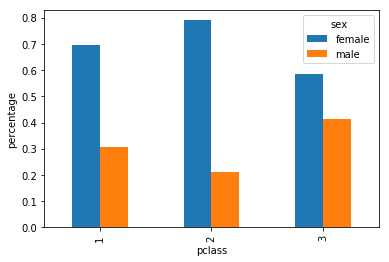

In [36]:
data = titanic[titanic['survived'] == 1]
data = data.groupby(['pclass', 'sex']).size().unstack()
data = data.divide(data.sum(axis=1),axis=0)
data.plot.bar()
plot.ylabel('percentage')
plot.show()

6.

In [10]:
ages_median=titanic['age'].median()

below = (titanic[titanic['age']<=ages_median]).copy()
below['Age category']="Below 28"
below_survived = below[below['survived'] == 1]
below_survived = below_survived.groupby(['Age category', 'pclass', 'sex']).size().unstack()
below_survived

above = (titanic[titanic['age']>ages_median]).copy()
above['Age category']="Above 28"
above_survived = above[above['survived'] == 1]
above_survived = above_survived.groupby(['Age category', 'pclass', 'sex']).size().unstack()
above_survived

final_frame = pd.DataFrame()
final_frame.append(below_survived).append(above_survived)

sex                  female  male
Age category pclass              
Below 28     1           39    17
             2           51    16
             3           56    41
Above 28     1           89    36
             2           41     7
             3           16    18